#PHASE 6 — LIVE INFERENCE PIPELINE

Load Models

In [8]:
import pandas as pd
import numpy as np
import joblib
import json
import time
import matplotlib.pyplot as plt

# Load models
soh_model = joblib.load("soh_model.pkl")
rul_model = joblib.load("rul_model.pkl")

# Load stored feature order
soh_feature_order = joblib.load("soh_feature_order.pkl")
rul_feature_order = joblib.load("rul_feature_order.pkl")

print("Models and feature order loaded successfully.")



Models and feature order loaded successfully.


Load Streaming Source

In [27]:
import random

FILE_PATH = "phase3_unified.jsonl"

with open(FILE_PATH, "r") as f:
    jsonl_lines = f.readlines()

print("Total telemetry records:", len(jsonl_lines))

# Shuffle once for realistic multi-device streaming
random.shuffle(jsonl_lines)

print("Streaming data shuffled successfully.")


Total telemetry records: 1515717
Streaming data shuffled successfully.


Live Feature Buffer

In [28]:
WINDOW_SIZE = 60
buffer = []

def compute_live_features(device_df):

    device_df = device_df.sort_values("timestamp")

    device_df["voltage_mean_60"] = device_df["pack_voltage"].rolling(60, min_periods=1).mean()
    device_df["voltage_std_60"] = device_df["pack_voltage"].rolling(60, min_periods=1).std()
    device_df["temp_mean_60"] = device_df["temperature"].rolling(60, min_periods=1).mean()
    device_df["current_mean_60"] = device_df["current"].rolling(60, min_periods=1).mean()
    device_df["dod"] = 100 - device_df["soc"]

    device_df = device_df.fillna(0)

    return device_df.iloc[-1:]


Streaming + Live Prediction

In [29]:
def live_stream_predict(max_records=300):

    streamed_output = []

    for idx, line in enumerate(jsonl_lines):

        if idx >= max_records:
            break

        record = json.loads(line)
        buffer.append(record)

        df_stream = pd.DataFrame(buffer)
        df_stream["timestamp"] = pd.to_datetime(df_stream["timestamp"])

        for device in df_stream["device_id"].unique():

            device_df = df_stream[df_stream["device_id"] == device].tail(WINDOW_SIZE)

            if len(device_df) < 10:
                continue  # wait until enough data collected

            latest_row = compute_live_features(device_df)

            drop_cols = ["device_id","timestamp","event","source"]
            X_live = latest_row.drop(columns=[c for c in drop_cols if c in latest_row.columns])

            # Align features exactly as training
            X_soh_live = X_live.reindex(columns=soh_feature_order, fill_value=0)
            X_rul_live = X_live.reindex(columns=rul_feature_order, fill_value=0)

            predicted_soh = soh_model.predict(X_soh_live)[0]
            predicted_rul_ratio = rul_model.predict(X_rul_live)[0]

            streamed_output.append({
                "timestamp": record["timestamp"],
                "device_id": device,
                "predicted_soh": predicted_soh,
                "predicted_rul_ratio": predicted_rul_ratio
            })

        time.sleep(0.05)

    return pd.DataFrame(streamed_output)


Run Live Simulation

In [30]:
live_predictions = live_stream_predict(max_records=1500)

print(live_predictions.head())
print("Total predictions generated:", len(live_predictions))


       timestamp   device_id  predicted_soh  predicted_rul_ratio
0  1771327513103  NASA_B0005       0.955363             0.780869
1  1771329502521  NASA_B0005       0.955363             0.780869
2  1771328028573  NASA_B0005       0.955363             0.780869
3  1771327047401  NASA_B0005       0.955363             0.780869
4  1771332265459  NASA_B0005       0.955363             0.780869
Total predictions generated: 10686


Convert RUL Ratio to Cycles

In [31]:
# Load full dataset to compute max cycle per device
full_df = pd.read_csv("phase3_unified.csv")
max_cycle_map = full_df.groupby("device_id")["cycle_count"].max().to_dict()

live_predictions["predicted_rul_cycles"] = live_predictions.apply(
    lambda x: x["predicted_rul_ratio"] * max_cycle_map.get(x["device_id"], 1),
    axis=1
)

print(live_predictions.head())


       timestamp   device_id  predicted_soh  predicted_rul_ratio  \
0  1771327513103  NASA_B0005       0.955363             0.780869   
1  1771329502521  NASA_B0005       0.955363             0.780869   
2  1771328028573  NASA_B0005       0.955363             0.780869   
3  1771327047401  NASA_B0005       0.955363             0.780869   
4  1771332265459  NASA_B0005       0.955363             0.780869   

   predicted_rul_cycles  
0            480.234659  
1            480.234659  
2            480.234659  
3            480.234659  
4            480.234659  


Save for Dashboard

In [32]:
live_predictions.to_csv("phase6_live_predictions.csv", index=False)
print("Phase 6 Live prediction file saved.")


Phase 6 Live prediction file saved.


Fleet SoH Overview (All Devices Together)

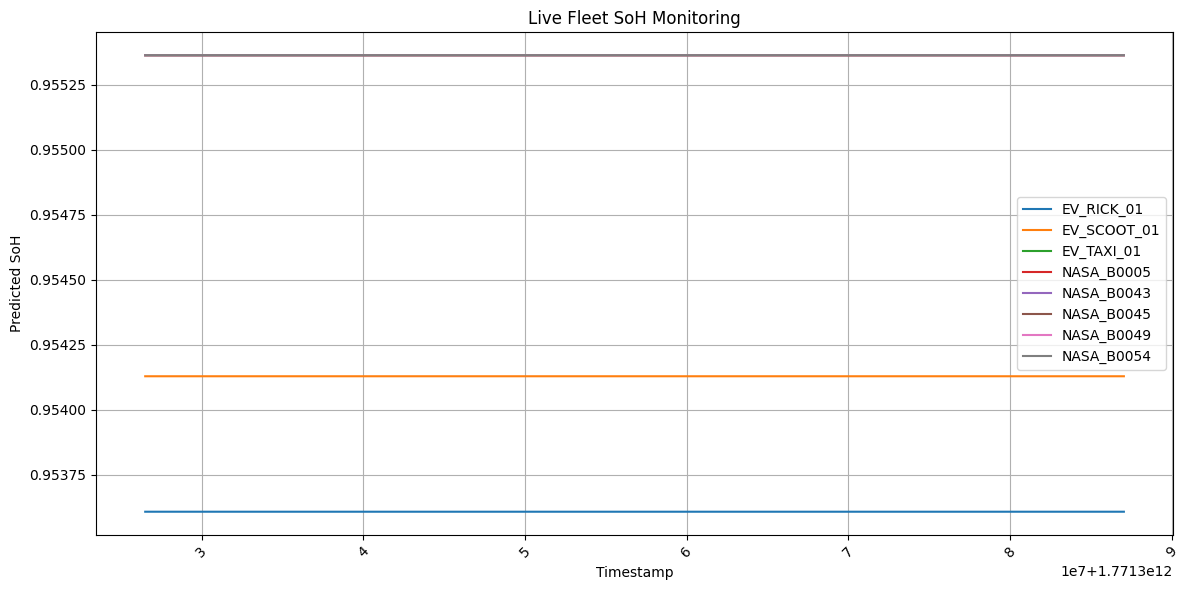

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

for device in sorted(live_predictions["device_id"].unique()):
    d = live_predictions[live_predictions["device_id"] == device]
    d = d.sort_values("timestamp")
    plt.plot(d["timestamp"], d["predicted_soh"], label=device)

plt.title("Live Fleet SoH Monitoring")
plt.xlabel("Timestamp")
plt.ylabel("Predicted SoH")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Fleet RUL Overview (All Devices)

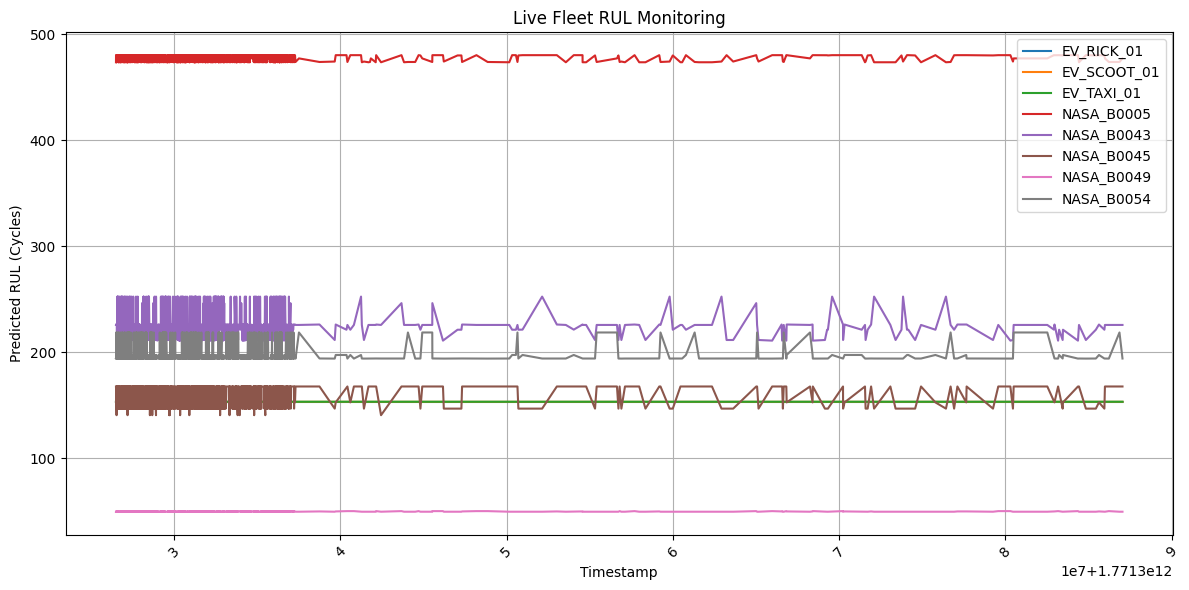

In [37]:
plt.figure(figsize=(12,6))

for device in sorted(live_predictions["device_id"].unique()):
    d = live_predictions[live_predictions["device_id"] == device]
    d = d.sort_values("timestamp")
    plt.plot(d["timestamp"], d["predicted_rul_cycles"], label=device)

plt.title("Live Fleet RUL Monitoring")
plt.xlabel("Timestamp")
plt.ylabel("Predicted RUL (Cycles)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Latest Fleet Snapshot (Dashboard Top Panel Data)

In [40]:
latest_snapshot = (
    live_predictions
    .sort_values("timestamp")
    .groupby("device_id")
    .tail(1)
)

print(latest_snapshot[[
    "device_id",
    "predicted_soh",
    "predicted_rul_cycles"
]])


        device_id  predicted_soh  predicted_rul_cycles
5728   NASA_B0005       0.955363            477.261275
5727   EV_RICK_01       0.953608            153.102973
5726   NASA_B0043       0.955363            225.795500
5733  EV_SCOOT_01       0.954129            153.244977
5732   NASA_B0049       0.955363             49.585047
5731   EV_TAXI_01       0.955363            153.335360
5730   NASA_B0054       0.955363            194.117906
5729   NASA_B0045       0.955363            167.734972


Health Status Categorisation

In [41]:
def health_status(soh):
    if soh > 0.9:
        return "Healthy"
    elif soh > 0.8:
        return "Moderate"
    else:
        return "Critical"

live_predictions["health_status"] = live_predictions["predicted_soh"].apply(health_status)

print(live_predictions.groupby(["device_id","health_status"]).size())


device_id    health_status
EV_RICK_01   Healthy          1212
EV_SCOOT_01  Healthy          1177
EV_TAXI_01   Healthy          1263
NASA_B0005   Healthy          1476
NASA_B0043   Healthy          1464
NASA_B0045   Healthy          1344
NASA_B0049   Healthy          1304
NASA_B0054   Healthy          1446
dtype: int64
